<a href="https://colab.research.google.com/github/muhhanifra/CGAN-anime-google-colab/blob/master/dcgan_anime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload() #upload your own kaggle.json

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') #we will use put the model inside a google drive after the training

In [ ]:
!kaggle datasets download -d soumikrakshit/anime-faces

 99% 438M/441M [00:05<00:00, 73.5MB/s]
100% 441M/441M [00:05<00:00, 82.9MB/s]


In [ ]:
import zipfile
zip_path = '/content/anime-faces.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_file:
  zip_file.extractall('dataset')

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from IPython import display
import os

from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, BatchNormalization,ReLU, MaxPooling2D,Flatten,Dense
from tensorflow.keras.layers import Reshape, Conv2DTranspose,Dropout,LeakyReLU

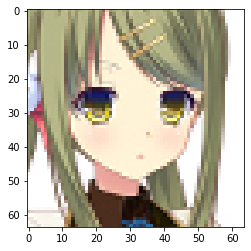

image size: (64, 64, 3)


In [ ]:
data_dir = '/content/dataset'
images_dir = os.path.join(data_dir, 'data')
image_filenames = os.listdir(images_dir)
#---see some images
image_path = os.path.join(images_dir,image_filenames[0])
img_sample = mpimg.imread(image_path)
plt.imshow(img_sample)
plt.show()

print('image size:',img_sample.shape)

In [ ]:
def normalize_img(img):
  return (img - 127.5)/127.5

In [ ]:
BATCH_SIZE = 64
it = ImageDataGenerator(preprocessing_function=normalize_img, horizontal_flip=False)
train_gen = it.flow_from_directory(data_dir, target_size=(64, 64), batch_size= BATCH_SIZE, class_mode= None, shuffle=True)

Found 43102 images belonging to 1 classes.


In [ ]:
#----------------creating discriminator-------------------
def create_discriminator():
  model = Sequential()
  
  model.add(Conv2D(32, (3,3), padding = 'same', input_shape = (64,64,3)))
  model.add(BatchNormalization())
  model.add(ReLU())
  
  model.add(Conv2D(32, (3,3), padding = 'same'))
  model.add(BatchNormalization())
  model.add(ReLU())

  model.add(MaxPooling2D((2,2)))

  model.add(Conv2D(64, (3,3), padding = 'same'))
  model.add(BatchNormalization())
  model.add(ReLU())
  
  model.add(Conv2D(64, (3,3), padding = 'same'))
  model.add(BatchNormalization())
  model.add(ReLU())

  model.add(MaxPooling2D((2,2)))

  model.add(Conv2D(128, (3,3), padding = 'same'))
  model.add(BatchNormalization())
  model.add(ReLU())
  
  model.add(Conv2D(128, (2,2), padding = 'same'))
  model.add(BatchNormalization())
  model.add(ReLU())

  model.add(MaxPooling2D((2,2)))

  model.add(Conv2D(64,(1,1),padding = 'valid'))
  model.add(BatchNormalization())
  model.add(ReLU())
  
  model.add(Flatten())
  model.add(Dense(1))

  return model

In [ ]:
disc = create_discriminator()
disc.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_64 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
re_lu_42 (ReLU)              (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_65 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
re_lu_43 (ReLU)              (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0

In [ ]:
def create_generator():
  n = 8
  model = Sequential()
  
  model.add(Dense(n*n*256, use_bias = False,input_shape = (128, )))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  #model.add(Dropout(0.7))

  model.add(Reshape((n,n,256)))

  model.add(Conv2DTranspose(128, (3,3),strides = (2,2), padding = 'same',use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(128,(3,3),strides = (1,1),padding = 'same', use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(64, (3,3),strides = (2,2), padding = 'same', use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(64,(3,3),strides = (1,1),padding = 'same', use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(32, (3,3),strides = (2,2), padding = 'same', use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(32, (3,3),strides = (1,1), padding = 'same', use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(16, (3,3),strides = (1,1), padding = 'same', use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(8,(1,1),strides = (1,1),padding = 'same', use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(3, (1, 1),strides = (1,1),padding = 'same',activation='tanh', use_bias = False))

  return model

In [ ]:
gen = create_generator()
gen.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 16384)             2097152   
_________________________________________________________________
batch_normalization_71 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_42 (Conv2DT (None, 16, 16, 128)       294912    
_________________________________________________________________
batch_normalization_72 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 16, 16, 128)      

In [ ]:
#defining losses
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(true_output, fake_output):
  disc_term = cross_entropy(tf.ones_like(true_output, dtype=tf.float32)*0.9,true_output) #one sided label smoothing
  gen_term = cross_entropy(tf.zeros_like(fake_output),fake_output)
  loss = disc_term + gen_term
  return loss

def generator_loss(fake_output):
  loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  return loss

In [ ]:
#defining optimizer
disc_opt = keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)
gen_opt = keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)

In [ ]:
num_epochs = 50
num_of_test = 64
seed = tf.random.normal([num_of_test,128])

In [ ]:
@tf.function
def train_step(x):
  noise = tf.random.normal([BATCH_SIZE,128])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_pred = gen(noise, training=True)

    disc_real = disc(x, training=True)
    disc_fake = disc(gen_pred, training = True)

    disc_loss = discriminator_loss(disc_real, disc_fake)
    gen_loss = generator_loss(disc_fake)

  gen_grads = gen_tape.gradient(gen_loss, gen.trainable_variables)
  disc_grads = disc_tape.gradient(disc_loss, disc.trainable_variables)

  gen_opt.apply_gradients(zip(gen_grads, gen.trainable_variables))
  disc_opt.apply_gradients(zip(disc_grads, disc.trainable_variables))

  return disc_loss, gen_loss

In [ ]:
def create_dir(path):
  try: 
      os.makedirs(path) 
      print("{} created".format(path)) 
  except: 
      print("skip, {} exist".format(path)) 

GAN_dir = '/content/GAN_5'
test_images_dir = os.path.join(GAN_dir, 'test_images')
checkpoints_dir = os.path.join(GAN_dir, 'model_checkpoints')

create_dir(GAN_dir)
create_dir(test_images_dir)
create_dir(checkpoints_dir)

skip, /content/GAN_5 exist
skip, /content/GAN_5/test_images exist
skip, /content/GAN_5/model_checkpoints exist


In [ ]:
def save_and_visualize_test(generator, discriminator,progress,seed, n_square = 8, dir = '/content/GAN'):
  #test generator on seed values
  test_fake_images = generator(seed, training = False)
  test_fake_images = np.uint8((test_fake_images*127.5) + 127.5)

  fig = plt.figure(figsize = (n_square,n_square))
  for i in range(n_square*n_square):
    plt.subplot(n_square,n_square,i+1)
    plt.imshow(test_fake_images[i, :,:,:])
    plt.axis('off')
  plt.show()
  #save models and sample images
  test_images_dir = os.path.join(dir, 'test_images')
  checkpoints_dir = os.path.join(dir, 'model_checkpoints')
  # save model
  generator.save(os.path.join(checkpoints_dir,'epoch-{}-step-{}-generator.hdf5'.format(progress['epoch'], progress['step'])))
  discriminator.save(os.path.join(checkpoints_dir,'epoch-{}-step-{}-discriminator.hdf5'.format(progress['epoch'], progress['step'])))
  # save images
  fig.savefig(os.path.join(test_images_dir,'epoch-{}-step-{}.jpg'.format(progress['epoch'], progress['step'])))

In [ ]:
m = train_gen.samples

epoch: 49 step: 600
disc_loss: 0.4811062 , gen_loss: 3.1645765


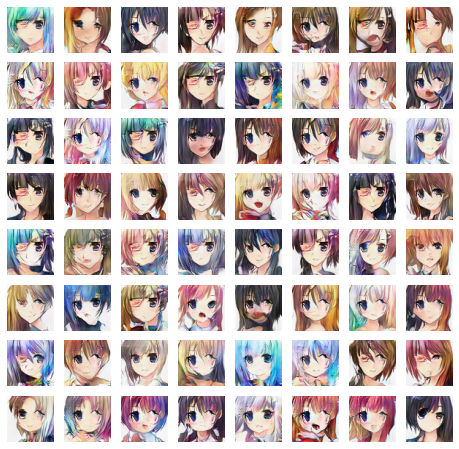

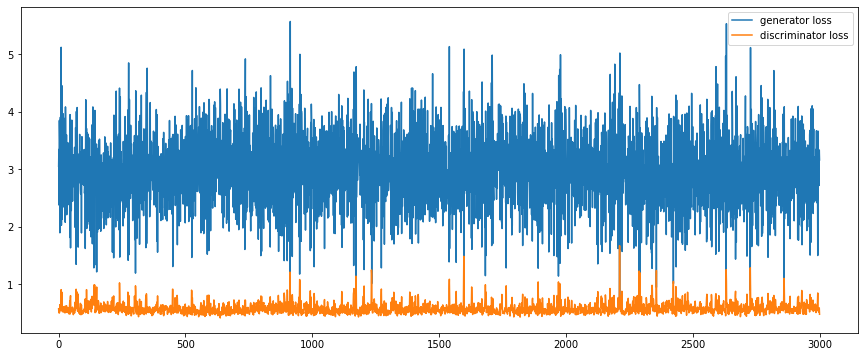

In [ ]:
num_steps = int(m/BATCH_SIZE)
disc_losses = []
gen_losses = []
for epoch in range(num_epochs):
  for step in range(num_steps):
    #minimax game with optimizer
    disc_loss, gen_loss = train_step(train_gen.next())
    #store models losses
    gen_losses.append(gen_loss.numpy())
    disc_losses.append(disc_loss.numpy())

    if step%100 == 0:
      #clear notebook output
      display.clear_output(wait=True)

      #print, visualize, and save progress
      progress = {'epoch':epoch, 'step':step}
      print('epoch:', epoch, 'step:', step)
      print('disc_loss:',disc_loss.numpy(), ', gen_loss:', gen_loss.numpy())
      save_and_visualize_test(gen,disc, progress, seed, dir = GAN_dir)

      #---plot discriminator and generator losss
      plt.figure(figsize=(15,6))
      plt.plot(gen_losses[-3000:])
      plt.plot(disc_losses[-3000:])
      plt.legend(['generator loss', 'discriminator loss'])
      plt.show()

In [ ]:
import shutil
shutil.make_archive("GAN_5", "zip", GAN_dir)
shutil.move('/content/GAN_5.zip', '/content/gdrive/My Drive')